Fit CNN in PyTorch
===


<div class="alert alert-warning">Optimizations to do:<ul><li>Image augmentation: not applied on single images but on a batch for better performance.</li><li>Test newly implemented image augmentation methods: rotation range to 360°, shear, random resize crops more balanced, color, blur, contrast</li><li>Image augmentation: Discuss impact of augmentation on the individual MDS dimensions (Dimensions, "lightness", "shape", "organisation" (or a possible dimension "size") impaired by harsh crops, resizings, brightness?).</li><li>Learning rate: Discuss usage of lr scheduler (torch.optim.lr_scheduler)</li></ul></div>

## Imports

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, models, transforms, utils
from torchmetrics import R2Score
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import cv2
import PIL
from PIL import Image
from skimage import io, transform
from glob import glob


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# number of models
n_ensemble = 10

# size of test and validation set
n_test = 90

# Number of dimensions in the dataset
n_dim = 8

# Batch size for training (change depending on how much memory you have)
batch_size_im = 90
batch_size_ft = 30

# Number of epochs to train for 
num_epochs_im = 500
num_epochs_ft = 500

# where would we use these in pytorch? in keras they are used to create layers for the intermediate model
dropout = 0.5 
n_dense = 256
n_layers = 2

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract_im = True
feature_extract_ft = False

input_size = 224

loglr = -2.2200654426745987
lr_im = 1 * 10 ** loglr
lr_ft = 2e-3

# create categories of stones for stratified train test split
categories = [i for i in range(30) for j in range(12)] # creates 360 list items like so: [0, 0, 0, 0, ... 29, 29, 29, 29]

IMG_360 = '../sanders_2018/360 Rocks/'
IMG_120 = '../sanders_2018/120 Rocks/'
MDS_360 = '../finetuning_torchvision_data/mds_360.csv'
CHECKPOINTS = 'CNN_checkpoints/'
PATH_IM = CHECKPOINTS + 'intermediate_model.pt'
PATH_FT = CHECKPOINTS + 'finetuned_model.pt'


print("Device is", device)

Device is cuda


## Functions, classes

In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=14, is_inception=False):
    """
    handles the training and validation of a given model. At the end of
    training returns the best performing model. After each epoch, the training and validation
    accuracies are printed
    """
    
    since = time.time()

    val_acc_history = []
    lrs = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = None
    
    r2score = R2Score(num_outputs=8).to(device)
    
    early_stopping = EarlyStopping(25)
    
    for epoch in range(num_epochs):
        print(f'Epoch {str(epoch + 1).rjust(len(str(num_epochs)))}/{num_epochs}', end=": ")
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_r2 = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    score = r2score(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # scheduler.step()
                        lr = optimizer.param_groups[0]["lr"]
                        lrs.append(lr)

                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_r2 += score.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset) 
            epoch_acc = running_r2 / len(dataloaders[phase].dataset) 
            # print only if phase is validation
            if phase == "val":
                print(f'Loss = {epoch_loss: .4f}, Score = {epoch_acc: .4f}, lr = {lr: .4e}')
                early_stopping(epoch_loss)

            # deep copy the model
            if phase == 'val' and best_acc == None:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        # early stopping if no improvement in the last 20 epochs
        if early_stopping.early_stop:
            print("Early stopped.")
            break
                

        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, lrs


def set_parameter_requires_grad(model, feature_extracting):
    """
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True
    return None


class RocksData(datasets.VisionDataset):
    def __init__(self, df, root_dir, transform=None):
        super(RocksData).__init__()
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]
        img = cv2.imread(img_path)
        img = PIL.Image.fromarray(img)  
        label = deepcopy(self.df.iloc[ix,1:].tolist())
        label = torch.tensor(label).float()
        img = self.transform(img)
        return img.to(device), label
 
    
class PredictionData(datasets.VisionDataset): # TODO: lots of redundant code. integrate this into above RocksData dataset
    def __init__(self, img_paths):
        super(PredictionData).__init__()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        self.img_paths = img_paths
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, ix):
        img = cv2.imread(self.img_paths[ix])/255.
        img = self.preprocess_input(img)
        return img
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device) 
    
    
def get_criterion(loss_name):
    """
    Returns the optimizer
    """
    if loss_name == "L1":
        return torch.nn.L1Loss()
    elif loss_name == "L2":
        return torch.nn.MSELoss()
    elif loss_name == "smooth_L1":
        return torch.nn.SmoothL1Loss()
    elif loss_name == "huber":
        return torch.nn.HuberLoss()
    else:
        raise Exception("No valid loss_name entered!")
        

def load_pretrained_model(stage="intermediate", e=None, model_type=None):
    
    if (model_type == None) | (model_type == "resnet"):
        model = models.resnet50()
    elif model_type == "regnet":
        model = models.regnet_y_16gf()
    set_parameter_requires_grad(model, feature_extract_ft)
    num_ftrs = model.fc.in_features
    new_layers = OutputLayers(n_layers, num_ftrs, n_dense, dropout)
    model.fc = new_layers # replace last layer
    
    if model_type == None:
        if e == None:
            checkpoint = torch.load(CHECKPOINTS + f'{stage}_model.pt', map_location=device)
        else:
            checkpoint = torch.load(CHECKPOINTS + f'{stage}_model_{e}.pt', map_location=device)
    else:
        checkpoint = torch.load(CHECKPOINTS + f'{stage}_{model_type}.pt', map_location=device)
    
    model.load_state_dict(checkpoint)

    # Send the model to GPU
    return model.to(device)


def predict(model, data_loader, unlabeled=False):
    """Computes predictions for a given mnodel and dataset"""
    
    model.eval()

    outputs = list()
    since = time.time()
    with torch.no_grad():
        if unlabeled:
            for inputs in data_loader:
                inputs = inputs.to(device)
                output = model(inputs)
                outputs.append(output.to("cpu").squeeze().numpy())
        else:
            for inputs, _ in data_loader:
                inputs = inputs.to(device)
                output = model(inputs)
                outputs.append(output.to("cpu").squeeze().numpy())

    return np.array(outputs)


class EarlyStopping():
    def __init__(self, tolerance=20):

        self.tolerance = tolerance
        self.counter = 0
        self.early_stop = False
        self.best_loss = np.nan

    def __call__(self, val_loss):
        if val_loss >= self.best_loss:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

## Prepare Data

### Define image transforms

In [16]:
# define image transformations
#data_transforms = {
#    'train': transforms.Compose([
#        transforms.RandomResizedCrop(input_size),
#        transforms.RandomHorizontalFlip(),
#        transforms.RandomVerticalFlip(),
#        transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), shear=(0.2, 0.2, 0.2, 0.2), scale=(0.8, 1.2)),
#        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#    ]),
#    'val': transforms.Compose([
#        transforms.Resize(input_size),
#        transforms.CenterCrop(input_size),
#        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#    ]),
#}

# define image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(1, 1), ratio=(.33, 2.5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomAffine(degrees=360, translate=(0.2, 0.2), shear=(-16, 16, -16, 16), scale=(0.75, 1.)),
        transforms.RandomAffine(degrees=360, translate=(0.2, 0.2), shear=(-16, 16, -16, 16), scale=(0.8, 1.4)), 
        transforms.ColorJitter(brightness=(.95, 1.05), contrast=(.9, 1.1), saturation=(0.95, 1.15)), # new
        #transforms.GaussianBlur(kernel_size=(1, 1), sigma=(.01, .5)), # new
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Create dataset and dataloaders

In [17]:
df = pd.read_csv(MDS_360)


# split data: train vs test
(train, test,
categories_train_, categories_test) = train_test_split(df,
                                                       categories,
                                                       test_size=n_test,
                                                       stratify=categories,
                                                       random_state=0)

# split train set again: train vs validate
train, val = train_test_split(train,
                              test_size=n_test,
                              stratify=categories_train_, 
                              random_state=0)

# create image datasets
train_dataset = RocksData(train.reset_index(drop=True), root_dir=IMG_360, transform=data_transforms["train"])
val_dataset = RocksData(val.reset_index(drop=True), root_dir=IMG_360, transform=data_transforms["val"])
test_dataset = RocksData(test.reset_index(drop=True), root_dir=IMG_360, transform=data_transforms["val"])
pred_dataset = PredictionData(glob(IMG_120+'*.jpg'))

## Adapt model

This is how the final layers look like in Keras:

```
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================

avg_pool (GlobalAveragePooling  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 2D)                                                                                              
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['dropout[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256)         1024        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout_1 (Dropout)            (None, 256)          0           ['batch_normalization[0][0]']    
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dropout_1[0][0]']              
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256)         1024        ['dense_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout_2 (Dropout)            (None, 256)          0           ['batch_normalization_1[0][0]']  
                                                                                                  
 dense_2 (Dense)                (None, 8)            2056        ['dropout_2[0][0]']       
```

In [18]:
from collections import OrderedDict

class OutputLayers(nn.Sequential):
    def __init__(self, n_layers, num_ftrs, n_dense, dropout):
        super().__init__(self.init_modules(n_layers, num_ftrs, n_dense, dropout))


    def init_modules(self, n_layers, num_ftrs, n_dense, dropout):
        modules = OrderedDict()
        
        i = 0
        modules[f"dropout_{i}"] = nn.Dropout(p=dropout)
        modules[f"fc_{i}"] = nn.Linear(num_ftrs, n_dense)
        
        for i in range(1, n_layers):           
            modules[f"relu_{i}"] = nn.ReLU(inplace=True)
            modules[f"batchnorm_{i}"] = nn.BatchNorm1d(n_dense)
            modules[f"dropout_{i}"] = nn.Dropout(p=dropout)
            modules[f"fc_{i}"] = nn.Linear(n_dense, n_dense)

        modules[f"relu_{i+1}"] = nn.ReLU(inplace=True)
        modules[f"batchnorm_{i+1}"] = nn.BatchNorm1d(n_dense)
        modules[f"dropout_{i+1}"] = nn.Dropout(p=dropout)
        modules[f"fc_{i+1}"] = nn.Linear(n_dense, n_dim)

        return modules

## Train one model ...
... for testing purposes, comparing learning rates etc.

Intermediate model

## Train ensemble

Changes 7.7. 19:00
* lr Adagrad = 5e-3 => poor, high loss
* lrAdagrad = 5e-4

Changes 7.7. 16:28:
* lr Adagrad = 1e-4 instead of 1e-3
=> poor results R² = .67

Changes 6.7.:
* Intermediate model for each finetuned model
* no GaussianBlur
* early stop at 25 instead of 20 epochs without loss reduction

Epoch   1/500: Loss =  6.2257, Score =  0.0653, lr =  2.0000e-03
Epoch   2/500: Loss =  2.8860, Score =  0.5248, lr =  2.0000e-03
Epoch   3/500: Loss =  2.1582, Score =  0.6240, lr =  2.0000e-03
Epoch   4/500: Loss =  2.0451, Score =  0.6499, lr =  2.0000e-03
Epoch   5/500: Loss =  1.9337, Score =  0.6657, lr =  2.0000e-03
Epoch   6/500: Loss =  1.8642, Score =  0.6829, lr =  2.0000e-03
Epoch   7/500: Loss =  1.7898, Score =  0.6947, lr =  2.0000e-03
Epoch   8/500: Loss =  1.7996, Score =  0.6836, lr =  2.0000e-03
Epoch   9/500: Loss =  1.6847, Score =  0.7050, lr =  2.0000e-03
Epoch  10/500: Loss =  1.6584, Score =  0.7114, lr =  2.0000e-03
Epoch  11/500: Loss =  1.6498, Score =  0.7154, lr =  2.0000e-03
Epoch  12/500: Loss =  1.6945, Score =  0.7061, lr =  2.0000e-03
Epoch  13/500: Loss =  1.8038, Score =  0.6893, lr =  2.0000e-03
Epoch  14/500: Loss =  1.7045, Score =  0.7077, lr =  2.0000e-03
Epoch  15/500: Loss =  1.6012, Score =  0.7225, lr =  2.0000e-03
Epoch  16/500: Loss =  1.

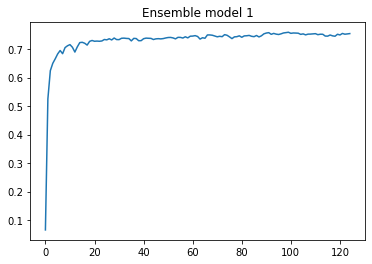

Epoch   1/500: Loss =  2.9386, Score =  0.5033, lr =  2.0000e-03
Epoch   2/500: Loss =  2.3984, Score =  0.5884, lr =  2.0000e-03
Epoch   3/500: Loss =  2.0319, Score =  0.6455, lr =  2.0000e-03
Epoch   4/500: Loss =  2.0065, Score =  0.6545, lr =  2.0000e-03
Epoch   5/500: Loss =  1.8117, Score =  0.6825, lr =  2.0000e-03
Epoch   6/500: Loss =  1.8827, Score =  0.6766, lr =  2.0000e-03
Epoch   7/500: Loss =  1.8151, Score =  0.6861, lr =  2.0000e-03
Epoch   8/500: Loss =  1.7625, Score =  0.6939, lr =  2.0000e-03
Epoch   9/500: Loss =  1.8843, Score =  0.6763, lr =  2.0000e-03
Epoch  10/500: Loss =  1.7229, Score =  0.7003, lr =  2.0000e-03
Epoch  11/500: Loss =  1.7009, Score =  0.7036, lr =  2.0000e-03
Epoch  12/500: Loss =  1.8214, Score =  0.6869, lr =  2.0000e-03
Epoch  13/500: Loss =  1.7128, Score =  0.7048, lr =  2.0000e-03
Epoch  14/500: Loss =  1.7267, Score =  0.7024, lr =  2.0000e-03
Epoch  15/500: Loss =  1.6134, Score =  0.7212, lr =  2.0000e-03
Epoch  16/500: Loss =  1.

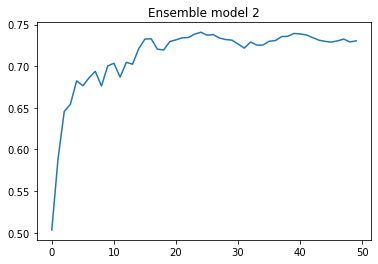

Epoch   1/500: Loss =  4.5329, Score =  0.3061, lr =  2.0000e-03
Epoch   2/500: Loss =  2.5631, Score =  0.5620, lr =  2.0000e-03
Epoch   3/500: Loss =  2.3054, Score =  0.5941, lr =  2.0000e-03
Epoch   4/500: Loss =  2.0741, Score =  0.6384, lr =  2.0000e-03
Epoch   5/500: Loss =  1.7933, Score =  0.6812, lr =  2.0000e-03
Epoch   6/500: Loss =  1.8225, Score =  0.6811, lr =  2.0000e-03
Epoch   7/500: Loss =  1.7906, Score =  0.6787, lr =  2.0000e-03
Epoch   8/500: Loss =  1.7934, Score =  0.6847, lr =  2.0000e-03
Epoch   9/500: Loss =  1.7111, Score =  0.6972, lr =  2.0000e-03
Epoch  10/500: Loss =  1.6818, Score =  0.6987, lr =  2.0000e-03
Epoch  11/500: Loss =  1.6549, Score =  0.7049, lr =  2.0000e-03
Epoch  12/500: Loss =  1.7736, Score =  0.6922, lr =  2.0000e-03
Epoch  13/500: Loss =  1.6973, Score =  0.6987, lr =  2.0000e-03
Epoch  14/500: Loss =  1.6505, Score =  0.7069, lr =  2.0000e-03
Epoch  15/500: Loss =  1.6764, Score =  0.7032, lr =  2.0000e-03
Epoch  16/500: Loss =  1.

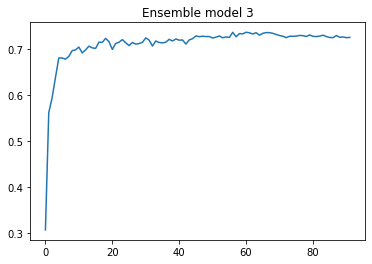

Epoch   1/500: Loss =  5.1720, Score =  0.2262, lr =  2.0000e-03
Epoch   2/500: Loss =  3.8092, Score =  0.3803, lr =  2.0000e-03
Epoch   3/500: Loss =  2.3360, Score =  0.6127, lr =  2.0000e-03
Epoch   4/500: Loss =  2.3166, Score =  0.6260, lr =  2.0000e-03
Epoch   5/500: Loss =  1.9084, Score =  0.6755, lr =  2.0000e-03
Epoch   6/500: Loss =  1.6799, Score =  0.7079, lr =  2.0000e-03
Epoch   7/500: Loss =  1.7013, Score =  0.7052, lr =  2.0000e-03
Epoch   8/500: Loss =  1.7099, Score =  0.7026, lr =  2.0000e-03
Epoch   9/500: Loss =  1.6555, Score =  0.7075, lr =  2.0000e-03
Epoch  10/500: Loss =  1.6514, Score =  0.7092, lr =  2.0000e-03
Epoch  11/500: Loss =  1.6461, Score =  0.7103, lr =  2.0000e-03
Epoch  12/500: Loss =  1.5550, Score =  0.7224, lr =  2.0000e-03
Epoch  13/500: Loss =  1.6101, Score =  0.7137, lr =  2.0000e-03
Epoch  14/500: Loss =  1.6881, Score =  0.7099, lr =  2.0000e-03
Epoch  15/500: Loss =  1.5221, Score =  0.7301, lr =  2.0000e-03
Epoch  16/500: Loss =  1.

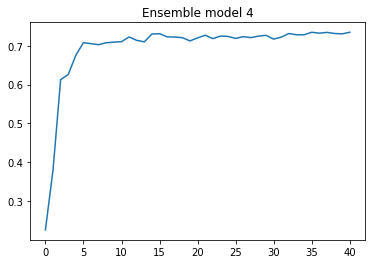

Epoch   1/500: Loss =  4.6954, Score =  0.2796, lr =  2.0000e-03
Epoch   2/500: Loss =  3.0549, Score =  0.4963, lr =  2.0000e-03
Epoch   3/500: Loss =  2.1280, Score =  0.6335, lr =  2.0000e-03
Epoch   4/500: Loss =  2.0719, Score =  0.6412, lr =  2.0000e-03
Epoch   5/500: Loss =  2.0832, Score =  0.6410, lr =  2.0000e-03
Epoch   6/500: Loss =  1.6455, Score =  0.7124, lr =  2.0000e-03
Epoch   7/500: Loss =  1.8039, Score =  0.6898, lr =  2.0000e-03
Epoch   8/500: Loss =  1.6737, Score =  0.7099, lr =  2.0000e-03
Epoch   9/500: Loss =  1.5996, Score =  0.7208, lr =  2.0000e-03
Epoch  10/500: Loss =  1.6346, Score =  0.7152, lr =  2.0000e-03
Epoch  11/500: Loss =  1.6690, Score =  0.7091, lr =  2.0000e-03
Epoch  12/500: Loss =  1.6262, Score =  0.7125, lr =  2.0000e-03
Epoch  13/500: Loss =  1.5819, Score =  0.7177, lr =  2.0000e-03
Epoch  14/500: Loss =  1.6438, Score =  0.7077, lr =  2.0000e-03
Epoch  15/500: Loss =  1.6232, Score =  0.7135, lr =  2.0000e-03
Epoch  16/500: Loss =  1.

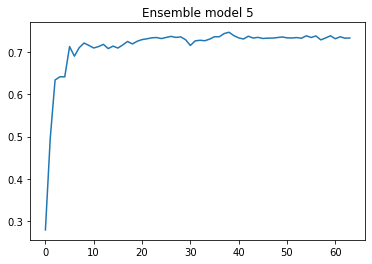

Epoch   1/500: Loss =  3.5846, Score =  0.4110, lr =  2.0000e-03
Epoch   2/500: Loss =  3.5787, Score =  0.3893, lr =  2.0000e-03
Epoch   3/500: Loss =  2.2886, Score =  0.5888, lr =  2.0000e-03
Epoch   4/500: Loss =  2.0987, Score =  0.6228, lr =  2.0000e-03
Epoch   5/500: Loss =  1.8566, Score =  0.6685, lr =  2.0000e-03
Epoch   6/500: Loss =  1.7387, Score =  0.6874, lr =  2.0000e-03
Epoch   7/500: Loss =  1.8142, Score =  0.6812, lr =  2.0000e-03
Epoch   8/500: Loss =  1.6534, Score =  0.7041, lr =  2.0000e-03
Epoch   9/500: Loss =  1.6674, Score =  0.7068, lr =  2.0000e-03
Epoch  10/500: Loss =  1.7049, Score =  0.7026, lr =  2.0000e-03
Epoch  11/500: Loss =  1.7524, Score =  0.6935, lr =  2.0000e-03
Epoch  12/500: Loss =  1.7111, Score =  0.6958, lr =  2.0000e-03
Epoch  13/500: Loss =  1.5805, Score =  0.7155, lr =  2.0000e-03
Epoch  14/500: Loss =  1.6319, Score =  0.7124, lr =  2.0000e-03
Epoch  15/500: Loss =  1.6061, Score =  0.7140, lr =  2.0000e-03
Epoch  16/500: Loss =  1.

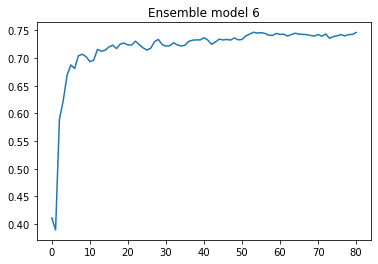

Epoch   1/500: Loss =  4.4866, Score =  0.2957, lr =  2.0000e-03
Epoch   2/500: Loss =  2.7944, Score =  0.5199, lr =  2.0000e-03
Epoch   3/500: Loss =  1.9438, Score =  0.6609, lr =  2.0000e-03
Epoch   4/500: Loss =  2.1176, Score =  0.6358, lr =  2.0000e-03
Epoch   5/500: Loss =  1.9294, Score =  0.6662, lr =  2.0000e-03
Epoch   6/500: Loss =  1.6872, Score =  0.7028, lr =  2.0000e-03
Epoch   7/500: Loss =  1.6939, Score =  0.7042, lr =  2.0000e-03
Epoch   8/500: Loss =  1.7109, Score =  0.6993, lr =  2.0000e-03
Epoch   9/500: Loss =  1.6584, Score =  0.7094, lr =  2.0000e-03
Epoch  10/500: Loss =  1.6892, Score =  0.7044, lr =  2.0000e-03
Epoch  11/500: Loss =  1.6619, Score =  0.7079, lr =  2.0000e-03
Epoch  12/500: Loss =  1.7236, Score =  0.7001, lr =  2.0000e-03
Epoch  13/500: Loss =  1.6509, Score =  0.7085, lr =  2.0000e-03
Epoch  14/500: Loss =  1.6162, Score =  0.7183, lr =  2.0000e-03
Epoch  15/500: Loss =  1.6174, Score =  0.7165, lr =  2.0000e-03
Epoch  16/500: Loss =  1.

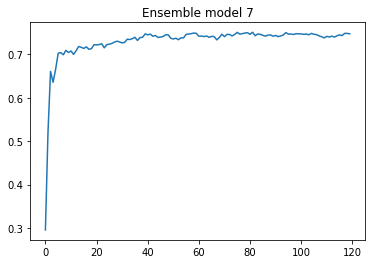

Epoch   1/500: Loss =  5.2247, Score =  0.1586, lr =  2.0000e-03
Epoch   2/500: Loss =  2.5406, Score =  0.5596, lr =  2.0000e-03
Epoch   3/500: Loss =  2.2395, Score =  0.6112, lr =  2.0000e-03
Epoch   4/500: Loss =  2.3900, Score =  0.5867, lr =  2.0000e-03
Epoch   5/500: Loss =  1.9559, Score =  0.6535, lr =  2.0000e-03
Epoch   6/500: Loss =  1.7169, Score =  0.6913, lr =  2.0000e-03
Epoch   7/500: Loss =  1.7973, Score =  0.6824, lr =  2.0000e-03
Epoch   8/500: Loss =  1.7535, Score =  0.6895, lr =  2.0000e-03
Epoch   9/500: Loss =  1.7327, Score =  0.6957, lr =  2.0000e-03
Epoch  10/500: Loss =  1.6769, Score =  0.7019, lr =  2.0000e-03
Epoch  11/500: Loss =  1.7094, Score =  0.6951, lr =  2.0000e-03
Epoch  12/500: Loss =  1.7324, Score =  0.6980, lr =  2.0000e-03
Epoch  13/500: Loss =  1.6970, Score =  0.7001, lr =  2.0000e-03
Epoch  14/500: Loss =  1.8021, Score =  0.6855, lr =  2.0000e-03
Epoch  15/500: Loss =  1.6920, Score =  0.7032, lr =  2.0000e-03
Epoch  16/500: Loss =  1.

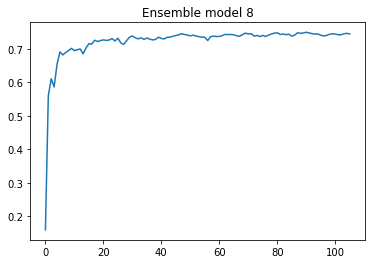

Epoch   1/500: Loss =  3.9064, Score =  0.3400, lr =  2.0000e-03
Epoch   2/500: Loss =  2.4006, Score =  0.5831, lr =  2.0000e-03
Epoch   3/500: Loss =  2.0782, Score =  0.6393, lr =  2.0000e-03
Epoch   4/500: Loss =  1.9487, Score =  0.6649, lr =  2.0000e-03
Epoch   5/500: Loss =  1.8755, Score =  0.6664, lr =  2.0000e-03
Epoch   6/500: Loss =  1.8621, Score =  0.6642, lr =  2.0000e-03
Epoch   7/500: Loss =  1.7830, Score =  0.6778, lr =  2.0000e-03
Epoch   8/500: Loss =  1.6076, Score =  0.7102, lr =  2.0000e-03
Epoch   9/500: Loss =  1.7124, Score =  0.6951, lr =  2.0000e-03
Epoch  10/500: Loss =  1.6661, Score =  0.7031, lr =  2.0000e-03
Epoch  11/500: Loss =  1.6652, Score =  0.6999, lr =  2.0000e-03
Epoch  12/500: Loss =  1.6386, Score =  0.7059, lr =  2.0000e-03
Epoch  13/500: Loss =  1.6019, Score =  0.7118, lr =  2.0000e-03
Epoch  14/500: Loss =  1.6145, Score =  0.7078, lr =  2.0000e-03
Epoch  15/500: Loss =  1.6452, Score =  0.7042, lr =  2.0000e-03
Epoch  16/500: Loss =  1.

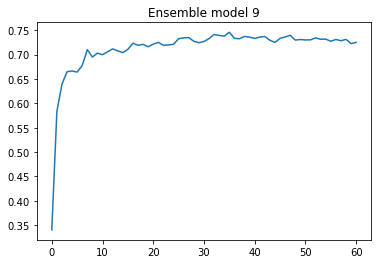

Epoch   1/500: Loss =  3.7326, Score =  0.3954, lr =  2.0000e-03
Epoch   2/500: Loss =  2.1881, Score =  0.6246, lr =  2.0000e-03
Epoch   3/500: Loss =  1.9251, Score =  0.6602, lr =  2.0000e-03
Epoch   4/500: Loss =  1.7429, Score =  0.6965, lr =  2.0000e-03
Epoch   5/500: Loss =  1.7219, Score =  0.7028, lr =  2.0000e-03
Epoch   6/500: Loss =  1.6427, Score =  0.7159, lr =  2.0000e-03
Epoch   7/500: Loss =  1.6493, Score =  0.7194, lr =  2.0000e-03
Epoch   8/500: Loss =  1.6843, Score =  0.7160, lr =  2.0000e-03
Epoch   9/500: Loss =  1.6220, Score =  0.7237, lr =  2.0000e-03
Epoch  10/500: Loss =  1.6238, Score =  0.7225, lr =  2.0000e-03
Epoch  11/500: Loss =  1.5677, Score =  0.7301, lr =  2.0000e-03
Epoch  12/500: Loss =  1.5393, Score =  0.7324, lr =  2.0000e-03
Epoch  13/500: Loss =  1.5304, Score =  0.7343, lr =  2.0000e-03
Epoch  14/500: Loss =  1.5298, Score =  0.7340, lr =  2.0000e-03
Epoch  15/500: Loss =  1.5566, Score =  0.7298, lr =  2.0000e-03
Epoch  16/500: Loss =  1.

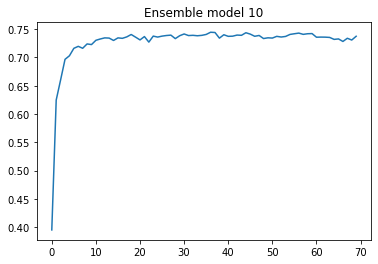

In [19]:
new_im_each_epoch = True # False means using the same intermediate model for all ensemble models


for e in range(1, n_ensemble + 1):
    
       
    # each epoch a new intermediate model?
    if new_im_each_epoch:
        
        # check if model for this epoch already exists
        intermediate_available = os.path.isfile(CHECKPOINTS + f"intermediate_model_{e}.pt")
        
        if intermediate_available == False:

            # Intermediate model
            model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            set_parameter_requires_grad(model, feature_extract_im)
            num_ftrs = model.fc.in_features
            new_layers = OutputLayers(n_layers, num_ftrs, n_dense, dropout)
            model.fc = new_layers # replace last layer

            # Send the model to GPU
            model = model.to(device)

            # create datalaoders with specific batch size
            train_loader = DataLoader(train_dataset, batch_size=batch_size_im)
            val_loader = DataLoader(val_dataset, batch_size=batch_size_im)
            dataloaders_dict = {"train":train_loader,"val":val_loader}

            # Create Optimizer and define params to update
            params_to_update = model.parameters()
            if feature_extract_im:
                params_to_update = []
                for name,param in model.named_parameters():
                    if param.requires_grad == True:
                        params_to_update.append(param)
                        #print("\t",name)

            else:
                for name,param in model.named_parameters():
                    if param.requires_grad == True:
                        #print("\t",name)
                        ...

            # Instantiate optimizer for intermediate model
            optimizer = optim.Adam(params_to_update, lr=lr_im)

            # Setup the loss fxn
            criterion = get_criterion('L2')

            # Initial training and evaluate
            model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs_im)

            # Plot learning curve
            plt.plot(hist)
            plt.title(f'Intermediate model {e}')
            plt.show()

            # Save intermediate model
            PATH_EN = f'CNN_checkpoints/intermediate_model_{e}.pt'
            torch.save(model.state_dict(), PATH_EN)
            del model
        model = load_pretrained_model("intermediate", e=e)
        
    else: # load a standard intermediate model
        model = load_pretrained_model("intermediate")

    # fine tuning
    
    # create dataloaders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_ft)
    dataloaders_dict = {"train":train_loader,"val":val_loader}
            
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    if feature_extract_ft:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                #print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                #print("\t",name)
                ...

    # Instantiate optimizer for finetuning
    # optimizer = optim.SGD(params_to_update, lr=lr_ft, momentum=0.9)
    optimizer = optim.Adagrad(params_to_update, lr=lr_ft)
   
    # Setup the loss fxn
    criterion = get_criterion("L2")

    # Train and evaluate fine tuned model
    model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs_ft)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title(f'Ensemble model {e}')
    plt.show()
    
    # Save intermediate model
    PATH_EN = f'CNN_checkpoints/ensemble_model_{e}.pt'
    torch.save(model.state_dict(), PATH_EN)

change: LR 2e-03 instead of 1e-01

next try:

* 9e-4
* 1.2e-3

## Load checkpoints and get predictions for validation and test sets

### Create dataloaders for inference

In [20]:
pred_loader = DataLoader(pred_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

### Run ensemble models (CNNs) ...
... to collect their individual predictions

In [21]:
#n_ensemble = 4

test_pred_ = []
rocks_120_pred_ = []

for e in range(1, n_ensemble+1):
    model = load_pretrained_model("ensemble", e)
    pred = predict(model, test_loader)
    test_pred_.append(pred)
    rocks_120_pred_.append(predict(model, pred_loader, unlabeled=True))
    
del model

test_pred = np.mean(test_pred_, 0)
rocks_120_pred = np.mean(rocks_120_pred_, 0)

rocks_120_pred_ = np.array(rocks_120_pred_)

### Get MSE

In [22]:
# get labels
Y_120 = np.loadtxt("../sanders_2018/mds_120.txt")
Y_validate = train.iloc[:, 1:].values
Y_test = test.iloc[:, 1:].values

In [23]:
print(mean_squared_error(Y_test, test_pred)) # same MDS space
print(mean_squared_error(Y_120, rocks_120_pred)) # not part of MDS space

1.4642399863674251
2.5477934553344794


### Get R²

In [24]:
print(r2_score(Y_test, test_pred))
print(r2_score(Y_120, rocks_120_pred))

0.7473663279980941
-0.21169224573576984


### Get Pearson's *r* for invidivual dimensions in Rocks 120 set

In [41]:
m_i = [7, 10, 3, 6, 8] # add models to a custom ensemble

###

rocks_120_pred_custom = np.mean(rocks_120_pred_[[i-1 for i in m_i], :, :], 0)

cnn_pred_file = "CNN Predictions/MDS Dimensions/cnn_predicted_mds_120.txt"
cnn_pred = np.loadtxt(cnn_pred_file)

cnn_keras_pred_file = "CNN Predictions/MDS Dimensions/cnn_keras_predicted_mds_120.txt"
cnn_keras_pred = np.loadtxt(cnn_keras_pred_file)

df_corr = pd.DataFrame(index=range(1,9))

for dim in range(1, 9):
    df_corr.loc[dim, "Keras Sanders & Nosofsky"] = np.corrcoef(cnn_pred[:, dim-1], Y_120[:, dim-1]).min()
    df_corr.loc[dim, "Keras replicated"] = np.corrcoef(cnn_keras_pred[:, dim-1], Y_120[:, dim-1]).min()
    df_corr.loc[dim, "PyTorch ensemble"] = np.corrcoef(rocks_120_pred[:, dim-1], Y_120[:, dim-1]).min()
    df_corr.loc[dim, "PyTorch custom"] = np.corrcoef(rocks_120_pred_custom[:, dim-1], Y_120[:, dim-1]).min()
    for i in range(len(rocks_120_pred_)):
        df_corr.loc[dim, f"PyTorch {i+1}"] = np.corrcoef(rocks_120_pred_[i, :, dim-1], Y_120[:, dim-1]).min()
    
df_corr.loc["Total", :] = df_corr.mean(axis=0)
df_corr["Best model"] = df_corr.columns[df_corr.values.argmax(axis=1)]

df_corr.T[["Total"]].drop("Best model", axis=0).sort_values("Total", ascending=False)

,Total
Keras replicated,0.683814
Keras Sanders & Nosofsky,0.676178
PyTorch custom,0.670676
PyTorch ensemble,0.667118
PyTorch 7,0.665288
PyTorch 10,0.659874
PyTorch 3,0.65938
PyTorch 6,0.659062
PyTorch 8,0.658766
PyTorch 9,0.653089


In [42]:
df_corr

,Keras Sanders & Nosofsky,Keras replicated,PyTorch ensemble,PyTorch custom,PyTorch 1,PyTorch 2,PyTorch 3,PyTorch 4,PyTorch 5,PyTorch 6,PyTorch 7,PyTorch 8,PyTorch 9,PyTorch 10,Best model
1,0.879750,0.877838,0.883712,0.883434,0.886212,0.876408,0.871823,0.874023,0.848371,0.858369,0.888881,0.876121,0.867317,0.875104,PyTorch 7
2,0.850301,0.826120,0.824094,0.825438,0.832792,0.780767,0.797255,0.817990,0.794438,0.808526,0.807665,0.841822,0.798541,0.816191,Keras Sanders & Nosofsky
3,0.378968,0.358630,0.383698,0.387890,0.379930,0.313894,0.363235,0.401981,0.375306,0.388125,0.385278,0.371623,0.382847,0.398816,PyTorch 4
4,0.838155,0.831899,0.847241,0.849988,0.852596,0.834544,0.830306,0.805598,0.822627,0.833911,0.841242,0.862474,0.818798,0.827752,PyTorch 8
5,0.484210,0.548242,0.441367,0.439940,0.404436,0.430482,0.476080,0.402043,0.448268,0.441629,0.484475,0.377418,0.452560,0.365429,Keras replicated
6,0.841105,0.857191,0.885537,0.887664,0.862817,0.880554,0.901777,0.876824,0.870933,0.859881,0.883967,0.866742,0.869645,0.877624,PyTorch 3
7,0.477049,0.496715,0.398594,0.403361,0.366149,0.409888,0.362090,0.348225,0.375476,0.404609,0.367617,0.405405,0.402008,0.420100,Keras replicated
8,0.659885,0.673881,0.672704,0.687690,0.621612,0.659232,0.672474,0.620591,0.656739,0.677452,0.663178,0.668525,0.632995,0.697979,PyTorch 10
Total,0.676178,0.683814,0.667118,0.670676,0.650818,0.648221,0.659380,0.643409,0.649020,0.659062,0.665288,0.658766,0.653089,0.659874,Keras replicated


### Save predictions to file

In [27]:
np.savetxt("CNN Predictions/MDS Dimensions/cnn_torch_ensemble10_22-07-08_predicted_mds_120.txt", rocks_120_pred_custom)

---
### Idea of using a meta learner (LinearRegression, ElasticNet or similar) ...
... to find optimally weighted mean of CNN predictions.

$Y_{pred} =  b_0 + b_1 Y_{pred_1} + b_2 Y_{pred_2}$

<div class="alert-warning"><ul><li>According to their paper Sanders & Nosofsky were not using a meta-learner, they were training an ensemble of 10 models and averaging them.</li><li>Making a custom ensemble by adding only a selection of all trained models and adding some models twice or more times we can quickly see that weights can improve the performance. However, the differences with this simple method were only marginal compared to the differences that we see between models on certain dimensions such as shape or organization. Thus, the latter issue should be tackled first.</ul></div>